In [12]:
import torch
from torch import nn
import torch.nn.functional as F
import math
import pickle
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import random


In [4]:
import networkx as nx


In [6]:
with open('data/raw/combo.pkl', 'rb') as f:
    my_data = pickle.load(f)

with open('data/raw/pos_neg_index_data.pkl', 'rb') as f:
    pos_neg_idx_data = pickle.load(f)

In [7]:
tree_rooted = my_data["tree_rooted(dict)"]
positive_pairs = pos_neg_idx_data["positive_pairs"]
negetive_pairs = pos_neg_idx_data["negetive_pairs"]


In [44]:
tree_message = TreeMatrixMessage(tree_rooted)
adj_matrix = tree_message.make_adjacency_matrix()
all_neg_pairs = []
for i in range(13308):
    if i % 100 == 0:
        print(i)
    for j in range(13308):
        if adj_matrix[i, j] != 1 and i != j:
            all_neg_pairs.append([i, j])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300


In [45]:
print(len(all_neg_pairs))

177076249


In [48]:
negetive_pairs = random.sample(all_neg_pairs, 13307)

In [49]:
len(negetive_pairs)

13307

In [50]:
pos_neg_idx_data["negetive_pairs"] = negetive_pairs
with open("data/raw/pos_neg_index_data.pkl", "wb") as f:
    pickle.dump(pos_neg_idx_data, f)

In [13]:
edge = tree_rooted["Edge"]
Number_of_Nodes = tree_rooted["Number_of_Nodes"]
Tip_Labels = tree_rooted["Tip_Labels"]
edge_lengths = tree_rooted["Edge_Lengths"]
Node_Labels = tree_rooted["Node_Labels"]

In [15]:
edge, edge_lengths

([[12694, 6054],
  [12694, 6055],
  [12693, 12694],
  [12693, 6056],
  [12692, 12693],
  [12692, 6057],
  [12691, 6047],
  [12691, 6048],
  [12690, 6045],
  [12690, 6046],
  [12689, 6044],
  [12689, 12690],
  [12688, 12689],
  [12688, 12691],
  [12687, 6042],
  [12687, 6043],
  [12686, 6041],
  [12686, 12687],
  [12685, 12686],
  [12685, 12688],
  [12684, 6040],
  [12684, 12685],
  [12683, 12684],
  [12683, 6049],
  [12682, 6037],
  [12682, 6038],
  [12681, 6036],
  [12681, 12682],
  [12680, 12681],
  [12680, 6039],
  [12679, 6034],
  [12679, 6035],
  [12678, 12679],
  [12678, 12680],
  [12677, 6033],
  [12677, 12678],
  [12676, 12677],
  [12676, 12683],
  [12675, 12676],
  [12675, 6050],
  [12674, 12675],
  [12674, 6051],
  [12673, 12674],
  [12673, 6052],
  [12672, 6029],
  [12672, 6030],
  [12671, 12672],
  [12671, 6031],
  [12670, 12671],
  [12670, 6032],
  [12669, 12670],
  [12669, 12673],
  [12668, 12669],
  [12668, 6053],
  [12667, 6023],
  [12667, 6024],
  [12666, 6022],
  [126

In [6]:
# 将Edge和Edge_Lengths转换为PyTorch Tensor
edge_tensor = torch.tensor(tree_rooted['Edge'], dtype=torch.int32)
edge_lengths_tensor = torch.tensor(tree_rooted['Edge_Lengths'], dtype=torch.float)

In [8]:
class TreeMatrixMessage:
    def __init__(self, tree_data):
        # super(TreeMatrixMessage, self).__init__()
        self.tree_data = tree_data
        self.nodes_number = self.get_all_node_nums()

    def create_indexed_tensor(self):
        """
        创建一个索引张量，用于填充邻接矩阵或边长矩阵。
        :param tree_data: 包含系统发育树数据的字典。
        :return: 一个形状为 [边的数量, 2] 的张量，其中包含边的索引。
        """
        Edge = self.tree_data["Edge"]
        indices = torch.tensor(Edge)
        return indices

    def make_adjacency_matrix(self):
        """创建邻接矩阵"""
        indices = self.create_indexed_tensor()
        adjacency_matrix = torch.zeros(self.nodes_number, self.nodes_number, dtype=torch.float)

        adjacency_matrix[indices[:, 0] - 1, indices[:, 1] - 1] = 1
        return adjacency_matrix

    def make_edge_lengths_matrix(self, normalization=None):
        """创建边长矩阵"""
        Edge_Lengths = torch.tensor(self.tree_data["Edge_Lengths"])
        indices = self.create_indexed_tensor()
        
        # 边长归一化
        if normalization:
            Edge_Lengths = (Edge_Lengths - Edge_Lengths.mean()) / Edge_Lengths.std()

        # 需要确保 Edge_Lengths 的数据类型与 adjacency_matrix 一致
        edge_lengths_matrix = torch.zeros(self.nodes_number, self.nodes_number, dtype=torch.float)
        # _Edge_Lengths = Edge_Lengths.clone().detach()
        edge_lengths_matrix[indices[:, 0] - 1, indices[:, 1] - 1] = torch.tensor(Edge_Lengths.clone().detach())
        return edge_lengths_matrix

    def make_tree_matrix(self):
        """创建树矩阵, 包含邻接矩阵和边长矩阵"""
        adjacency_matrix = self.make_adjacency_matrix()
        edge_lengths_matrix = self.make_edge_lengths_matrix()
        return torch.where(adjacency_matrix == 1, edge_lengths_matrix, float('inf'))
    

    def get_all_node_nums(self):
        """获得节点数量"""
        edge = self.tree_data["Edge"]
        
        node_set = {node for every_edge in edge for node in every_edge}
        return len(node_set)

    def get_edges_count(self):
        """获得边的数量"""
        edge_lengths = self.tree_data["Edge_Lengths"]
        
        return len(edge_lengths)
    

In [67]:
class GNN(torch.nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(1, 32)  # 假设边长矩阵是二维的（邻接+边长）
        self.conv2 = GCNConv(32, embedding_dim)
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # 第一层图卷积，使用边长矩阵作为边的特征
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        
        # 第二层图卷积
        x = self.conv2(x, edge_index, edge_attr)
        # x = F.relu(x)
        
        return x


In [78]:
def contrastive_loss(pos_embed, neg_embed, temperature=0.5):
    """
    对比损失函数，用于拉近正样本对的距离，推开负样本对的距离。
    
    参数:
    - pos_embed: 正样本对的嵌入表示，形状为 [num_positive_pairs, 2, embedding_dim]
    - neg_embed: 负样本对的嵌入表示，形状为 [num_negative_pairs, 2, embedding_dim]
    - temperature: 用于缩放嵌入相似度的参数
    """
    # 计算所有正样本对之间的相似度
    pos_embed_normalized = torch.nn.functional.normalize(pos_embed, dim=2)
    pos_similarity = torch.sum(pos_embed_normalized * pos_embed_normalized, dim=2)
    
    # 计算所有负样本对之间的相似度
    neg_embed_normalized = torch.nn.functional.normalize(neg_embed, dim=2)
    neg_similarity = torch.sum(neg_embed_normalized * neg_embed_normalized, dim=2) / temperature
    
    # 使用logsigmoid函数计算损失
    pos_loss = -torch.log(torch.sigmoid(pos_similarity)).mean()
    neg_loss = -torch.log(1 - torch.sigmoid(neg_similarity)).mean()
    
    return pos_loss + neg_loss


In [77]:
tree_message = TreeMatrixMessage(tree_rooted)
num_nodes = tree_message.get_all_node_nums()
embedding_dim = 64
num_epochs = 50

embedding_model = GNN(num_nodes, embedding_dim)
data = tree_rooted
edge_index, edge_attr = data["Edge"], data["Edge_Lengths"]
edge_index = [[x - 1 for x in edge] for edge in edge_index]
edge_index = torch.tensor(edge_index)
edge_attr = torch.tensor(edge_attr).unsqueeze(1)
data = Data(x=torch.zeros(13308, 1), edge_index=edge_index.t(), edge_attr=edge_attr)

data.batch = torch.zeros(num_nodes, dtype=torch.long).unsqueeze(1)

optimizer = torch.optim.Adam(embedding_model.parameters(), lr=0.001)
print(data.x.shape, data.edge_index.shape, data.edge_attr.shape, data.batch.shape)

torch.Size([13308, 1]) torch.Size([2, 13307]) torch.Size([13307, 1]) torch.Size([13308, 1])


In [40]:
torch.tensor(negetive_pairs).shape

torch.Size([0])

In [79]:
losses = []

# 训练模型
# embedding_model.train()
pos_indices = torch.tensor([p - 1 for pair in positive_pairs for p in pair], dtype=torch.long).unsqueeze(1).flatten()
neg_indices = torch.tensor([n for pair in negetive_pairs for n in pair], dtype=torch.long).unsqueeze(1).flatten()
# print(pos_indices.shape, neg_indices.shape)
# print(neg_indices.min().item())
for epoch in range(num_epochs):
    embedding_model.train()
    optimizer.zero_grad()
    out = embedding_model(data)
    # print(out.shape)
    pos_embed = torch.index_select(out, dim=0, index=pos_indices)
    neg_embed = torch.index_select(out, dim=0, index=neg_indices)

    pos_embed = pos_embed.view(-1, 2, 64)  # [num_positive_pairs, 2, embedding_dim]
    neg_embed = neg_embed.view(-1, 2, 64)
    # print(pos_embed.shape, neg_embed.shape)

    loss = contrastive_loss(pos_embed, neg_embed, temperature=0.5)
    loss.backward()
    optimizer.step()

    # 记录损失
    losses.append(loss.item())

    # 输出训练信息
    print(f'Epoch {epoch:03d}, Loss: {loss.item()}')

Epoch 000, Loss: 1.3862947225570679
Epoch 001, Loss: 1.3862947225570679
Epoch 002, Loss: 1.3862947225570679
Epoch 003, Loss: 1.3862947225570679
Epoch 004, Loss: 1.3862947225570679
Epoch 005, Loss: 1.3862947225570679
Epoch 006, Loss: 1.3862947225570679
Epoch 007, Loss: 1.3862947225570679
Epoch 008, Loss: 1.3862947225570679
Epoch 009, Loss: 1.3862947225570679
Epoch 010, Loss: 1.3862947225570679
Epoch 011, Loss: 1.3862947225570679
Epoch 012, Loss: 1.3862947225570679
Epoch 013, Loss: 1.3862947225570679
Epoch 014, Loss: 1.3862947225570679
Epoch 015, Loss: 1.3862947225570679
Epoch 016, Loss: 1.3862947225570679
Epoch 017, Loss: 1.3862947225570679
Epoch 018, Loss: 1.3862947225570679
Epoch 019, Loss: 1.3862947225570679
Epoch 020, Loss: 1.3862947225570679
Epoch 021, Loss: 1.3862947225570679
Epoch 022, Loss: 1.3862947225570679
Epoch 023, Loss: 1.3862947225570679
Epoch 024, Loss: 1.3862947225570679
Epoch 025, Loss: 1.3862947225570679
Epoch 026, Loss: 1.3862947225570679
Epoch 027, Loss: 1.386294722

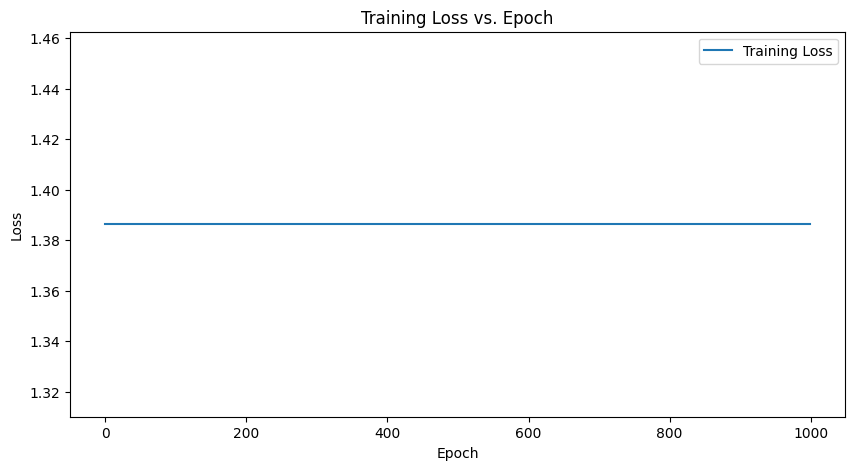

In [74]:
# 训练完成后，绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 显示图形
plt.show()

In [4]:
import pickle

import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv

In [5]:
with open("data/raw/combo.pkl", "rb") as f:
    my_data = pickle.load(f)

with open("data/raw/pos_neg_index_data.pkl", "rb") as f:
    pos_neg_data = pickle.load(f)

In [7]:
tree_rooted = my_data["tree_rooted(dict)"]

In [8]:
edge = tree_rooted["Edge"]
edge_lengths = tree_rooted["Edge_Lengths"]
print(type(edge), type(edge_lengths))

<class 'list'> <class 'list'>


In [19]:
# 构建图
num_nodes = 13308
num_edges = 13307
src_nodes, dst_nodes, edge_length = [], [], []
for i in range(num_edges):
    src, dst, length = edge[i][0] - 1, edge[i][1] - 1, edge_lengths[i]
    src_nodes.append(src)
    dst_nodes.append(dst)
    edge_length.append(length)

graph = dgl.graph((src_nodes, dst_nodes), num_nodes=num_nodes)
graph.edata['length'] = torch.tensor(edge_length, dtype=torch.float32)

node_features = []
for i in range(num_nodes):
    node_features.append(1)
graph.ndata["feat"] = torch.tensor(node_features)

In [11]:
# 定义GraphSAGE模型
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_size, 'mean')
        self.conv2 = SAGEConv(hidden_size, hidden_size, 'mean')
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, graph, feat):
        x = F.relu(self.conv1(graph, feat))
        x = F.relu(self.conv2(graph, x))
        x = self.fc(x)
        return x

In [20]:
print(graph.ndata['feat'].shape)
print(graph.edata['length'].shape)


torch.Size([13308])
torch.Size([13307])


In [ ]:
in_feats = 0
hidden_size = 64
num_classes = 128
num_epochs = 50

In [ ]:
# 初始化模型
model = GraphSAGE(in_feats + 1, hidden_size, num_classes) # 加1是因为加入了边长特征

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 训练模型
for epoch in range(num_epochs):
    model.train()
    logits = model(graph, torch.cat([graph.ndata['feat'], graph.edata['length']], dim=1)) # 将节点特征和边长特征拼接作为输入
    loss = criterion(logits[train_mask], labels[train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 使用训练好的模型进行预测
model.eval()
logits = model(graph, torch.cat([graph.ndata['feat'], graph.edata['length']], dim=1)) # 将节点特征和边长特征拼接作为输入

In [23]:
tree_message = TreeMatrixMessage(tree_rooted)
adj_matrix = tree_message.make_adjacency_matrix()
print(adj_matrix)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
def deepwalk_walk(self, walk_length, start_node):

    walk = [start_node]

    while len(walk) < walk_length:
        cur = walk[-1]
        cur_nbrs = list(self.G.neighbors(cur))
        if len(cur_nbrs) > 0:
            walk.append(random.choice(cur_nbrs))
        else:
            break
    return walk

def _simulate_walks(self, nodes, num_walks, walk_length,):
    walks = []
    for _ in range(num_walks):
        random.shuffle(nodes)
        for v in nodes:           
            walks.append(self.deepwalk_walk(alk_length=walk_length, start_node=v))
    return walks

results = Parallel(n_jobs=workers, verbose=verbose, )(
    delayed(self._simulate_walks)(nodes, num, walk_length) for num in
    partition_num(num_walks, workers))

walks = list(itertools.chain(*results))

In [26]:
import networkx as nx

In [16]:
DG = nx.DiGraph()
for i in range(13308):
    DG.add_node(i, feature=0)

for i in range(13307):
    cur_edge = edge[i]
    cur_edge_len = edge_lengths[i]
    start = cur_edge[0] - 1
    end = cur_edge[1] - 1
    DG.add_edge(start, end, length=cur_edge_len)

In [17]:
print(DG.neighbors(0))

In [4]:
import networkx as nx

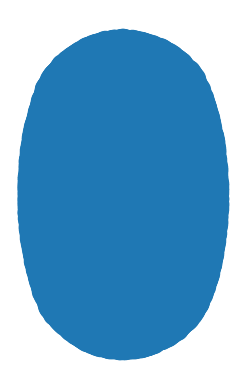

In [5]:
import matplotlib.pyplot as plt
subax1 = plt.subplot(121)
nx.draw(DiG)

In [ ]:
for u, v, d in DG.edges(data=True):
    DG[u][v]['weight'] = d['length']

In [1]:
from node2vec import Node2Vec

/Users/liaokechen/miniconda3/envs/microb/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:

def longest_continuous_edge_length(DG):
    max_length = 0

    for node in DG.nodes():
        visited = set()
        stack = [(node, 0)]

        while stack:
            current_node, length = stack.pop()
            visited.add(current_node)
            max_length = max(max_length, length)

            for neighbor in DG.neighbors(current_node):
                if neighbor not in visited:
                    stack.append((neighbor, length + 1))

    return max_length
print(longest_continuous_edge_length(DG))

62


In [26]:
node2vec = Node2Vec(DG, dimensions=128, walk_length=80, num_walks=300, p=0.5, q=2, weight_key="weight", workers=4)

# 训练模型
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# 获取嵌入向量
embedding = {node: model.wv[node] for node in DG.nodes()}

# 打印节点1的嵌入向量
print("节点1的嵌入向量:", embedding[1])

Generating walks (CPU: 4): 100%|██████████| 75/75 [00:03<00:00, 22.17it/s]


节点1的嵌入向量: [ 0.08311354 -0.28254232  1.3892584  -0.6901321   0.3609164  -0.6759595
  0.01539611  0.11693624  0.11541601  0.07523541  0.9544234  -0.07888988
 -0.24708647 -0.46675324 -0.69847536  0.05765482 -0.24468087 -0.50915086
 -0.22771722 -0.8712844   0.63047475 -0.02219786  1.044159   -1.0572481
 -0.12406667  0.788897   -0.31997618  0.30277762  0.08903094 -0.34554318
 -0.59643334 -0.02974115  0.5452204   0.13983607  0.39847916 -0.11318972
  0.84635395  0.39639637 -0.5337301   0.5518156   0.5602002   0.26099938
 -0.80706257 -1.0073885   0.92493916 -0.6556758  -1.0059019  -0.1019712
 -0.48399445  0.5303347   0.1709121   0.06538457 -0.5181542   0.10517003
 -0.64241594 -1.0574743   0.09104779 -0.6722981  -1.1769253   0.2182117
 -0.51380956 -0.6210956   0.9108713   0.810828    1.521699   -0.44465187
 -0.6376397   0.2268431  -0.15623733 -0.04388674 -0.2697221   0.00465162
 -1.023615   -0.38618     0.16113402  0.08169036 -0.23244953  1.2603756
 -1.1867923  -0.5041432  -0.9295015   0.740799

In [27]:
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('data/model/embedding.txt')

In [30]:
with open("data/raw/TreeRooted_graph.pkl", "wb") as f:
    pickle.dump(DG, f)

In [2]:
with open("data/raw/TreeRooted_graph.pkl", "rb") as f:
    DiG = pickle.load(f)

In [32]:
DiG.number_of_nodes()

13308

In [34]:
DiG.number_of_edges()

13307

In [35]:
DiG[12693][6053]

{'length': 0.0146, 'weight': 0.0146}

In [33]:
w = [[1, 1, 1, 1],
     [2, 2, 2, 2],
     [3, 3, 3, 3]]
w = torch.tensor(w, dtype=torch.float32)
h = nn.Linear(4, 2)
Wh = h(w) # (3, 2)
N = Wh.size()[0]
print(Wh.repeat(1, N).view(N * N, -1))
print(Wh.repeat(N, 1))
torch.cat([Wh.repeat(1, N).view(N * N, -1), Wh.repeat(N, 1)], dim=1)

tensor([[-0.6189,  0.4356],
        [-0.6189,  0.4356],
        [-0.6189,  0.4356],
        [-1.5306,  0.4744],
        [-1.5306,  0.4744],
        [-1.5306,  0.4744],
        [-2.4423,  0.5132],
        [-2.4423,  0.5132],
        [-2.4423,  0.5132]], grad_fn=<ViewBackward0>)
tensor([[-0.6189,  0.4356],
        [-1.5306,  0.4744],
        [-2.4423,  0.5132],
        [-0.6189,  0.4356],
        [-1.5306,  0.4744],
        [-2.4423,  0.5132],
        [-0.6189,  0.4356],
        [-1.5306,  0.4744],
        [-2.4423,  0.5132]], grad_fn=<RepeatBackward0>)


tensor([[-0.6189,  0.4356, -0.6189,  0.4356],
        [-0.6189,  0.4356, -1.5306,  0.4744],
        [-0.6189,  0.4356, -2.4423,  0.5132],
        [-1.5306,  0.4744, -0.6189,  0.4356],
        [-1.5306,  0.4744, -1.5306,  0.4744],
        [-1.5306,  0.4744, -2.4423,  0.5132],
        [-2.4423,  0.5132, -0.6189,  0.4356],
        [-2.4423,  0.5132, -1.5306,  0.4744],
        [-2.4423,  0.5132, -2.4423,  0.5132]], grad_fn=<CatBackward0>)

In [37]:
N = 3
out_features = 4
mat1 = torch.randn(N, 1, N)
mat2 = torch.randn(1, N, out_features)
result = torch.matmul(mat1, mat2)
result.shape

torch.Size([3, 1, 4])